In [1]:
%matplotlib inline
from pathlib import Path
import imp
import os
import matplotlib.pyplot as plot
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet101V2, Xception, ResNet50V2, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.imagenet as imagenetutils
import warnings
warnings.simplefilter('ignore')

from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
#setting seed to reproduce the same result every time the code is re-run
seed_num = 1
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
import gc
gc.enable()

2022-10-14 11:31:42.819297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 11:31:42.977751: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 11:31:43.827731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-14 11:31:43.827854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
target_size=(512,512)
target_shape=[512,512]
protein_name= 'GRIM19'
random_state=36
dataset_name='AllPatients' 
model_name='ResNet50V2'
model_name_PH='ResNet50'
nDNA_PH= ''

In [3]:
image_dir = Path(f"./Dataset_TIFF_{protein_name}/{nDNA_PH}split_512")

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.tiff'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
from skimage import data, exposure, img_as_float
def adaptive_stretch(img,c_limit=0.002):
    stretched_img = exposure.equalize_adapthist(img_as_float(img), clip_limit=c_limit)
    return stretched_img

def make_merge_channels(r,g,b):
    #b = np.zeros(r.shape)
    rgb_uint8 = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8) 
    return rgb_uint8
def get_green_red_image(img_file_path,b,protein_name,c_limit_dystrophin=0.15,c_limit_vdac=0.2, c_limit_b=0.2):
    r=adaptive_stretch(Image.open(img_file_path.replace(protein_name, 'Dystrophin')),c_limit=c_limit_dystrophin)
    g=adaptive_stretch(Image.open(img_file_path.replace(protein_name, 'VDAC1')),c_limit=c_limit_vdac)
    b=adaptive_stretch(b,c_limit=c_limit_b)
    rgb_image= make_merge_channels(r,g,b)
    return rgb_image
def get_g_r_image(img_file_path,protein_name,c_limit_dystrophin=0.15,c_limit_vdac=0.2, c_limit_b=0.2):
    r=adaptive_stretch(Image.open(img_file_path.replace(protein_name, 'Dystrophin')),c_limit=c_limit_dystrophin)
    g=adaptive_stretch(Image.open(img_file_path.replace(protein_name, 'VDAC1')),c_limit=c_limit_vdac)
    b=np.zeros(target_size)
    rgb_image= make_merge_channels(r,g,b)
    return rgb_image   
def get_g_r_i_image(img_file_path,protein_name,b,c_limit_dystrophin=0.15,c_limit_vdac=0.2):
    r=adaptive_stretch(Image.open(img_file_path.replace(protein_name, 'Dystrophin')),c_limit=c_limit_dystrophin)
    g=adaptive_stretch(Image.open(img_file_path.replace(protein_name, 'VDAC1')),c_limit=c_limit_vdac)
    b=np.copy(b)
    b=(1-b)*255
    # make all pixels > threshold black
    threshold = 15
    binarized = 1 * (b > threshold)
    rgb_image= make_merge_channels(r,g,binarized)
    return rgb_image 

In [5]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=random_state)

In [6]:
# Separate in train and test data
train_df, val_df = train_test_split(train_df, train_size=0.9, shuffle=True, random_state=random_state)

In [7]:
# making Tiny_test
test_df_n,tiny_test_df = train_test_split(test_df, train_size=0.6, shuffle=True, random_state=random_state)

In [8]:
train_datagen=ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
val_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)
tiny_test_datagen=ImageDataGenerator(rescale = 1./255)

In [9]:
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)
tiny_test_images = test_datagen.flow_from_dataframe(
    dataframe=tiny_test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

Found 220 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


In [10]:
model = load_model(f"./models/{protein_name}/{model_name_PH}_{protein_name}_512_Protein.h5")



2022-10-14 11:31:55.375838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 11:31:56.197016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0
2022-10-14 11:31:56.353376: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [11]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)/255
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

In [12]:
def get_data(test_dataframe,size):
    images_labels=[]
    
    for i in range(len(test_dataframe.Filepath)):
        #print(i)
        val= (get_img_array(test_dataframe.Filepath.iloc[i],size),test_dataframe.Label.iloc[i])
        images_labels.append(val)
        #labels.append(test_df.Label.iloc[i])
    return images_labels
        
        
    
    
    

In [13]:
# Get some example test set images.
image_size = target_size
image_shape =target_shape
images =get_data(tiny_test_df,size=image_size)

if not len(images):
    raise Exception(
        "Please download the example images using: "
        "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'"
    )

In [14]:

input_range = (-128, 128)  # format used by keras.applications
noise_scale = (input_range[1] - input_range[0]) * 0.1

# Methods we use and some properties.


methods = [
    # NAME                  OPT.PARAMS                  POSTPROC FXN            TITLE
    # Show input.
    ("input",               {},                         imagenetutils.image,    "Input"),
    # Function
    #("gradient",            {"postprocess": "abs"},     imagenetutils.graymap,  "Gradient"),
    #("smoothgrad",          {"augment_by_n": 64, 
    #                         "noise_scale": noise_scale, 
    #                         "postprocess": "square"},  imagenetutils.graymap,  "SmoothGrad"),
    # Signal
    #("deconvnet",           {},                         imagenetutils.bk_proj,  "Deconvnet"),
    #("guided_backprop",     {},                         imagenetutils.bk_proj,  "Guided Backprop"),
    # Interaction
    #("deep_taylor.bounded", {"low": input_range[0], 
    #                         "high": input_range[1]},   imagenetutils.heatmap,  "DeepTaylor"),
    #("input_t_gradient",    {},                         imagenetutils.heatmap,  "Input * Gradient"),
    #("integrated_gradients",
     #                       {"reference_inputs": input_range[0], 
     #                        "steps": 64},              imagenetutils.heatmap,  "Integrated Gradients"),
    #("lrp.z",               {},                         imagenetutils.heatmap,  "LRP-Z"),
    #("lrp.epsilon",         {"epsilon": 1},             imagenetutils.heatmap,  "LRP-Epsilon"),
    #("lrp.sequential_preset_a_flat",
     #                       {"epsilon": 1},             imagenetutils.heatmap,  "LRP-PresetAFlat"),
    ("lrp.sequential_preset_b_flat",
                            {"epsilon": 1},             imagenetutils.heatmap,  "LRP-PresetBFlat"),
]

In [15]:
# Create model without trailing softmax
model_wo_softmax = innvestigate.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(
            method[0],  # analysis method identifier
            model_wo_softmax,  # model without softmax output
            **method[1]
        )  # optional analysis parameters
    except innvestigate.NotAnalyzeableModelException:
        # Not all methods work with all models.
        analyzer = None
    analyzers.append(analyzer)

In [16]:
#from tensorflow.keras.applications import VGG16

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB"  # keras.applications use BGR format



analysis = np.zeros([len(images), len(analyzers)] + image_shape + [3])
text = []
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

for i, (x, y) in enumerate(images):
    # Add batch axis.
    #x1 = x[None, :, :, :]
    #x_pp = resnet50.preprocess_input(x1)
    x_pp= x
    print(x.shape)

    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x_pp)[0]
    prob = model.predict_on_batch(x_pp)[0]
    y_hat = prob.argmax()

    # Save prediction info:
    text.append(
        (
            "%s" % y,  # ground truth label
            "%.2f" % presm.max(),  # pre-softmax logits
            "%.2f" % prob.max(),  # probabilistic softmax output
            "%s" % labels[y_hat],  # predicted label
        )
    )

    for aidx, analyzer in enumerate(analyzers):
        if methods[aidx][0] == "input":
            # Do not analyze, but keep not preprocessed input.
            a = x / 255
        elif analyzer:
            # Analyze.
            print([aidx][0])
            a = analyzer.analyze(x_pp)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = imagenetutils.postprocess(a, color_conversion, channels_first)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
        else:
            a = np.zeros_like(image)
        # Store the analysis.
        analysis[i, aidx] = a[0]

(1, 512, 512, 3)


2022-10-14 11:32:01.884570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-14 11:32:02.354134: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1
(1, 512, 512, 3)
1


<Figure size 432x288 with 0 Axes>

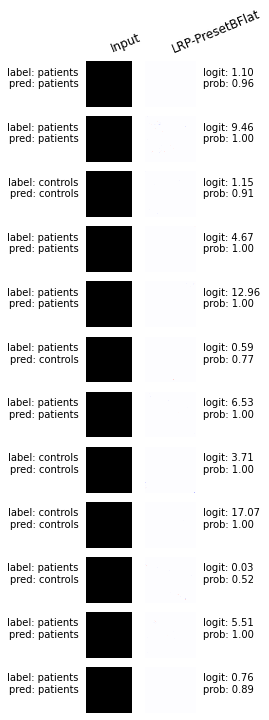

In [17]:
# Prepare the grid as rectangular list
grid = [
    [analysis[i, j] for j in range(analysis.shape[1])] for i in range(analysis.shape[0])
]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [
    ("label: {}".format(label[i]), "pred: {}".format(pred[i]))
    for i in range(len(label))
]
row_labels_right = [
    ("logit: {}".format(presm[i]), "prob: {}".format(prob[i]))
    for i in range(len(label))
]
col_labels = ["".join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(
    grid,
    row_labels_left,
    row_labels_right,
    col_labels,
    file_name=os.environ.get("plot_file_name", None),
)

In [18]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [19]:
def rgb2gray2(rgb):
    #rgb = 255 * rgb
    #rgb[np.where((rgb==[1,1,1]).all(axis=2))] = [0,0,0]
    
    return np.dot(rgb[...,:3], [0.5, 0.0,0.5])

In [20]:
def plot_per_method(rows,columns=3,figsize=(50,50),fontsize=40,c_limit_dystrophin=0.15,c_limit_vdac=0.2,c_limit_b=0.2,for_gradient_method_c_limit =0.05):
    f, axarr = plot.subplots(rows,columns,figsize=figsize)
    if col_labels[1] == 'Gradient':
        for_gradient_method_c_limit =0.05
    else:
        for_gradient_method_c_limit=0.00
        
        
    for j in range(rows):
        i=j+8
        
        if col_labels[1] == 'Gradient':
            axarr[j,0].imshow(get_green_red_image(tiny_test_df.Filepath.iloc[i],rgb2gray(grid[i][1]),protein_name,c_limit_dystrophin,c_limit_vdac,c_limit_b))
        elif col_labels[1]== 'Deconvnet':
            print('here')
            axarr[j,0].imshow(get_g_r_image(tiny_test_df.Filepath.iloc[i],protein_name,c_limit_dystrophin,c_limit_vdac,c_limit_b))
        elif col_labels[1]== 'Guided Backprop':
            print('here1')
            axarr[j,0].imshow(get_g_r_image(tiny_test_df.Filepath.iloc[i],protein_name,c_limit_dystrophin,c_limit_vdac,c_limit_b))
        
        else:
            axarr[j,0].imshow(get_g_r_i_image(tiny_test_df.Filepath.iloc[i],protein_name,rgb2gray2(grid[i][1]),c_limit_dystrophin,c_limit_vdac))
            
            print('there')
            
            
        axarr[j,0].set_title(f"Label: {text[i][0]}\nPredicted: {text[i][3]}\n",fontsize=fontsize)

        axarr[j,1].imshow(adaptive_stretch(grid[i][0],c_limit=0.02))
        axarr[j,1].set_title(f"{col_labels[0]}:{protein_name}",fontsize=fontsize)
        
        if col_labels[1] == 'Gradient':
            axarr[j,2].imshow(adaptive_stretch(grid[i][1],c_limit=for_gradient_method_c_limit))
        else:
            axarr[j,2].imshow(grid[i][1])   
          
                
        axarr[j,2].set_title(f"Method: {col_labels[1]}\nLogit:{text[i][1]},Prob:{text[i][2]}",fontsize=fontsize)
        f.tight_layout()
    return f, axarr
        
    

In [21]:
f, axarr=plot_per_method(2,3,(120,120),120,0.15,0.3)

there
there


In [22]:
def dir_create(path):
    
    if not os.path.exists(path):
        os.makedirs(path)
        
dir_path =f"./Results/{protein_name}_{dataset_name}/"

In [23]:
dir_create(dir_path)
file_path= os.path.join(dir_path,f"{model_name}_{protein_name}_{col_labels[1]}.png")
f.savefig(file_path)